In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
from nltk import FreqDist
from nltk.corpus import stopwords

import spacy

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import pyLDAvis.gensim
np.random.seed(2)

In [3]:
data = pd.read_excel('Rubber News.xlsx', error_bad_lines=False);

In [4]:
data.shape

(5275, 6)

In [5]:
data = data[["Full.story"]]
data= data.apply(lambda x: x.astype(str).str.lower())

In [6]:
data.shape

(5275, 1)

In [7]:
# data.rename(columns = {'Full.story':'full_story'}, inplace = True)

In [8]:
documents = data.copy()

In [9]:
documents

,Full.story
0,sumitomo rubber industries has established a n...
1,spot rubber closed unchanged on thursday. rss ...
2,delegate registration for india rubber meet 20...
3,mumbai – futures contracts of rubber on the in...
4,tapping has been delayed despite the fact that...
...,...
5270,"cogencis, wednesday, apr 11 new delhi – india’..."
5271,"cogencis, tuesday, apr 10 by prabhnoor nanda n..."
5272,outlook futures contracts of natural rubber ma...
5273,"cogencis, tuesday, apr 10 by shikha singh new ..."


In [10]:
documents[documents.index == 5027].values[0][0]

'cogencis, monday, jul 30 –source: india jun natural rubber use 102,000 tn, up 17.7% on year –india jun natural rubber imports 38,367 tn, up 14.7% on year –india natural rubber june-end stocks 232,000 tn by mugunthan kesavan new delhi – india’s natural rubber production fell 2.2% on year to 44,000 tn in june while consumption rose 17.7% to 102,000 tn, a rubber board source said. heavy rains in kerala, the top producer of rubber, have hit tapping in the last two months. with consumption shooting up and output declining, imports rose 14.7% on year to 38,367 tn in june, the source said. for apr-jun, natural rubber output was down 11.9% on year at 126,000 tn, while consumption was 14.2% higher at 302,000 tn. during the same period, imports rose 24.6% on year to 118,355 tn, the source said. india’s natural rubber inventory at the end of june was 232,000 tn, compared with 225,000 tn a year ago, the source said. the tyre industry has been demanding removal of port restrictions on natural rubb

In [11]:
documents['full_story'] = documents['Full.story'].map(lambda x: re.sub('[,\.!?]', '', x))
documents['full_story'] = documents['full_story'].str.replace("[^a-zA-Z#]", " ")
documents['full_story']= documents['full_story'].str.replace('  ', ' ')
documents['full_story']= documents['full_story'].str.replace('   ', ' ')
documents['full_story']= documents['full_story'].str.replace('    ', ' ')

<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-11-02b972e3a2b4>:1: DeprecationWarning: invalid escape sequence \.
  documents['full_story'] = documents['Full.story'].map(lambda x: re.sub('[,\.!?]', '', x))


In [12]:
documents[documents.index == 5027].values[0][1]

'cogencis monday jul source india jun natural rubber use  tn up on year india jun natural rubber imports  tn up on year india natural rubber june end stocks  tn by mugunthan kesavan new delhi  india s natural rubber production fell on year to  tn in june while consumption rose to  tn a rubber board source said heavy rains in kerala the top producer of rubber have hit tapping in the last two months with consumption shooting up and output declining imports rose on year to  tn in june the source said for apr jun natural rubber output was down on year at  tn while consumption was higher at  tn during the same period imports rose on year to  tn the source said india s natural rubber inventory at the end of june was  tn compared with  tn a year ago the source said the tyre industry has been demanding removal of port restrictions on natural rubber for all imports in june the government allowed imports of rubber meant for re export under advance authorisation scheme from any port in india unde

## EDA

In [13]:
from wordcloud import WordCloud

In [14]:
# Join the different processed titles together.
long_string = ','.join(list(documents['full_story'].values))

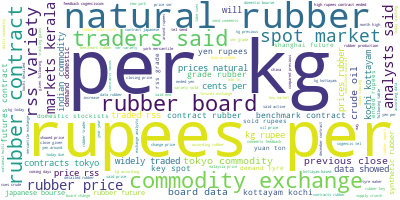

In [15]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=8, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [16]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

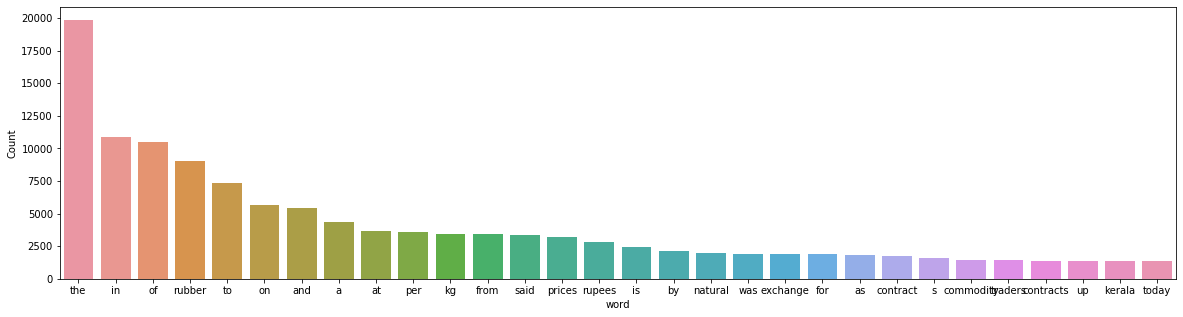

In [17]:
freq_words(documents['full_story'])

## Data processing

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = documents.full_story.values.tolist()
data_words = list(sent_to_words(data))

In [19]:
print(data_words[:1][0][:30])

['sumitomo', 'rubber', 'industries', 'has', 'established', 'natural', 'rubber', 'procurement', 'subsidiary', 'in', 'singapore', 'the', 'world', 'largest', 'natural', 'rubber', 'trading', 'hub']


### Creating Bi-Gram and Tri-Gram

In [20]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [21]:
my_stop_words = STOPWORDS.union(set(['send', 'comment', 'feedback', 'today', 'come', 'harsh', 'akshit', 'nishant', 'chakraborty', 
                                     'augustine', 'cogencis', 'com', 'rahul', 'dhuri', 'end-users','rupeesedited', 'mugunthan', 'kesavan', 
                                     'says', 'said', 'say', 'prabhnoor', 'nanda',"show","table","detail","give","geojit",
                                     'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'february',
                                     'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december' ]))


#                                      ,'kerla','delhi','kottayam','india','china','japanese','thailand','malaysia','tokyo',
#                                      "come","chinese","prabhnoor","shikha","singh","mumbai","rubber","kerala","kochi","make","board","data",
#                                      "grade","cents","iran"])) 

In [22]:
stop_words = stopwords.words('english')
stop_words.extend(my_stop_words)

In [23]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [25]:
print('original document: ')
print(data_words[:1][0][:30])
print('After lemmatization, tokenization:')
print(data_lemmatized[:1][0][:30])

original document: 
['sumitomo', 'rubber', 'industries', 'has', 'established', 'natural', 'rubber', 'procurement', 'subsidiary', 'in', 'singapore', 'the', 'world', 'largest', 'natural', 'rubber', 'trading', 'hub']
After lemmatization, tokenization:
['industry', 'establish', 'natural', 'rubber', 'subsidiary', 'large', 'natural', 'rubber', 'trading', 'hub']


In [26]:
words_after_preprocessing= list(itertools.chain.from_iterable(data_lemmatized))

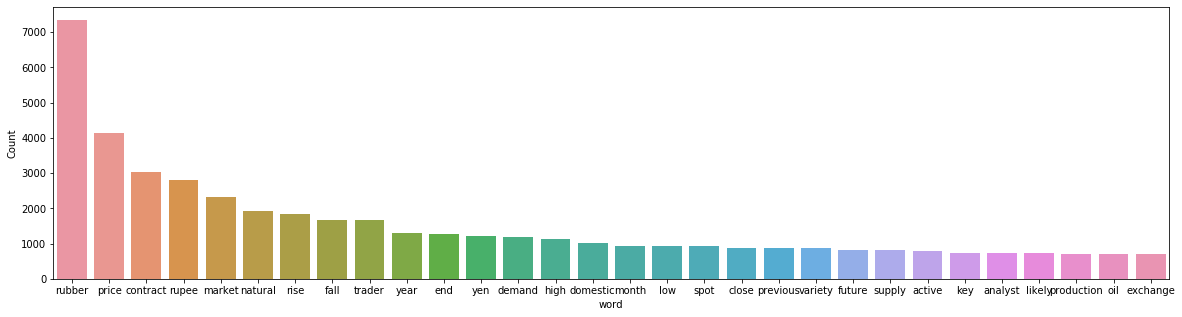

In [27]:
freq_words(words_after_preprocessing)

## Gensim doc2bow-- Creating dictionary from the data

In [28]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
print('After lemmatization, tokenization:')
print(data_lemmatized[:1][0][:30])
bow_doc_test_0 = corpus[0]
for i in range(len(bow_doc_test_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_test_0[i][0], 
                                               id2word[bow_doc_test_0[i][0]], 
                                                     bow_doc_test_0[i][1]))

After lemmatization, tokenization:
['industry', 'establish', 'natural', 'rubber', 'subsidiary', 'large', 'natural', 'rubber', 'trading', 'hub']
Word 0 ("establish") appears 1 time.
Word 1 ("hub") appears 1 time.
Word 2 ("industry") appears 1 time.
Word 3 ("large") appears 1 time.
Word 4 ("natural") appears 2 time.
Word 5 ("rubber") appears 2 time.
Word 6 ("subsidiary") appears 1 time.
Word 7 ("trading") appears 1 time.


## Saving pickle files

In [31]:
# pickle.dump(corpus, open('corpus_bow_ngram.pkl', 'wb'))
# id2word.save('dictionary_bow_ngram.gensim')

## LDA

In [32]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [33]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.088*"rubber" + 0.088*"price" + 0.073*"oil" + 0.071*"crude" + 0.032*"cue"')
(1, '0.060*"rubber" + 0.032*"price" + 0.020*"supply" + 0.017*"production" + 0.016*"low"')
(2, '0.022*"commodity" + 0.021*"receive" + 0.019*"company" + 0.016*"rubber" + 0.014*"government"')
(3, '0.068*"rubber" + 0.064*"year" + 0.037*"natural" + 0.033*"month" + 0.020*"ton"')
(4, '0.115*"rubber" + 0.088*"contract" + 0.054*"rupee" + 0.038*"yen" + 0.025*"end"')
(5, '0.083*"settle" + 0.025*"denominate" + 0.023*"comment" + 0.021*"market" + 0.020*"subdue"')
(6, '0.032*"plantation" + 0.027*"state" + 0.021*"government" + 0.019*"price" + 0.016*"sector"')
(7, '0.038*"future" + 0.031*"contract" + 0.023*"trade" + 0.023*"yen" + 0.023*"position"')
(8, '0.029*"market" + 0.016*"growth" + 0.015*"term" + 0.015*"tax" + 0.015*"rate"')
(9, '0.093*"price" + 0.057*"rubber" + 0.053*"market" + 0.053*"rupee" + 0.046*"trader"')


In [34]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.088*"rubber" + 0.088*"price" + 0.073*"oil" + 0.071*"crude" + 0.032*"cue" '
  '+ 0.029*"exchange" + 0.019*"substitute" + 0.019*"rise" + 0.016*"give" + '
  '0.016*"future"'),
 (1,
  '0.060*"rubber" + 0.032*"price" + 0.020*"supply" + 0.017*"production" + '
  '0.016*"low" + 0.016*"natural" + 0.016*"coming_day" + 0.014*"expect" + '
  '0.012*"high" + 0.012*"year"'),
 (2,
  '0.022*"commodity" + 0.021*"receive" + 0.019*"company" + 0.016*"rubber" + '
  '0.014*"government" + 0.013*"duty" + 0.012*"industry" + 0.012*"allow" + '
  '0.012*"product" + 0.011*"capacity"'),
 (3,
  '0.068*"rubber" + 0.064*"year" + 0.037*"natural" + 0.033*"month" + '
  '0.020*"ton" + 0.019*"production" + 0.019*"increase" + 0.017*"output" + '
  '0.017*"consumption" + 0.016*"country"'),
 (4,
  '0.115*"rubber" + 0.088*"contract" + 0.054*"rupee" + 0.038*"yen" + '
  '0.025*"end" + 0.023*"analyst" + 0.022*"fall" + 0.021*"active" + '
  '0.020*"close" + 0.020*"high"'),
 (5,
  '0.083*"settle" + 0.025*"denominate" + 0.023

In [36]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5396317471542709


## Optimal Topics

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

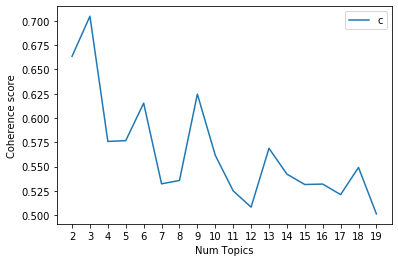

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                                        start=2, limit=20, step=1)
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.legend(("coherence_values"), loc='best')
plt.show()

## Topics- 3: Best model run

In [39]:
lda_model_best_3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                                 eta= 0.61)

In [40]:
# lda_model_best_3.save('model_lda_bow_ngram_best_3.gensim')

In [41]:
print(lda_model_best_3.print_topics())
# doc_lda_best = lda_model_best[bow_corpus]

[(0, '0.021*"month" + 0.018*"year" + 0.012*"index" + 0.009*"company" + 0.009*"inflation" + 0.009*"increase" + 0.008*"high" + 0.007*"rubber" + 0.007*"export" + 0.006*"state"'), (1, '0.110*"rubber" + 0.066*"price" + 0.034*"market" + 0.032*"natural" + 0.031*"rise" + 0.028*"fall" + 0.023*"oil" + 0.023*"domestic" + 0.022*"crude" + 0.021*"trader"'), (2, '0.090*"rupee" + 0.068*"rubber" + 0.055*"contract" + 0.047*"price" + 0.039*"yen" + 0.034*"close" + 0.025*"grade" + 0.024*"previous" + 0.019*"active" + 0.017*"rss"')]


In [42]:
topics_best_3 = lda_model_best_3.print_topics(num_words=5)
for topic in topics_best_3:
    print(topic)

(0, '0.021*"month" + 0.018*"year" + 0.012*"index" + 0.009*"company" + 0.009*"inflation"')
(1, '0.110*"rubber" + 0.066*"price" + 0.034*"market" + 0.032*"natural" + 0.031*"rise"')
(2, '0.090*"rupee" + 0.068*"rubber" + 0.055*"contract" + 0.047*"price" + 0.039*"yen"')


In [90]:
topics_best_3 = lda_model_best_3.print_topics(num_words=13)
for topic in topics_best_3:
    print(topic)

(0, '0.021*"month" + 0.018*"year" + 0.012*"index" + 0.009*"company" + 0.009*"inflation" + 0.009*"increase" + 0.008*"high" + 0.007*"rubber" + 0.007*"export" + 0.006*"state" + 0.006*"low" + 0.006*"plantation" + 0.006*"production"')
(1, '0.110*"rubber" + 0.066*"price" + 0.034*"market" + 0.032*"natural" + 0.031*"rise" + 0.028*"fall" + 0.023*"oil" + 0.023*"domestic" + 0.022*"crude" + 0.021*"trader" + 0.020*"contract" + 0.019*"demand" + 0.019*"likely"')
(2, '0.090*"rupee" + 0.068*"rubber" + 0.055*"contract" + 0.047*"price" + 0.039*"yen" + 0.034*"close" + 0.025*"grade" + 0.024*"previous" + 0.019*"active" + 0.017*"rss" + 0.016*"high" + 0.016*"low" + 0.016*"datum"')


In [45]:
coherence_model_lda_c_v_3 = CoherenceModel(model=lda_model_best_3, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_3 = coherence_model_lda_c_v_3.get_coherence()
print('Coherence Score for c_v: ', coherence_lda_3)

Coherence Score for c_v:  0.6172659695956492


In [48]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 40);
        word_dict['Topic ' + '{:d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [49]:
get_lda_topics(lda_model_best_3, 3)

,Topic 1,Topic 2,Topic 3
0,month,rubber,rupee
1,year,price,rubber
2,index,market,contract
3,company,natural,price
4,inflation,rise,yen
5,increase,fall,close
6,high,oil,grade
7,rubber,domestic,previous
8,export,crude,active
9,state,trader,rss


## Visualize topic keywords from best model

In [50]:
dictionary = gensim.corpora.Dictionary.load('dictionary_bow_ngram.gensim')
corpus = pickle.load(open('corpus_bow_ngram.pkl', 'rb'))
# lda = gensim.models.ldamodel.LdaModel.load('model_lda_bow_ngram_best_3.gensim')

In [51]:
lda_display = pyLDAvis.gensim.prepare(lda_model_best_3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\plohith\.conda\envs\rpg_env\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Topic-3: Train Data Mapping

In [91]:
documents_copy= documents.copy()

In [92]:
df_lemma = pd.DataFrame({'lemmatized':data_lemmatized})

In [93]:
documents_copy_df_lemma= pd.concat([documents_copy,df_lemma],axis=1)

In [94]:
documents_copy_df_lemma

,Full.story,full_story,lemmatized
0,sumitomo rubber industries has established a n...,sumitomo rubber industries has established a n...,"[industry, establish, natural, rubber, subsidi..."
1,spot rubber closed unchanged on thursday. rss ...,spot rubber closed unchanged on thursday rss ...,"[spot, rubber, close, unchanged, rss, quote, s..."
2,delegate registration for india rubber meet 20...,delegate registration for india rubber meet i...,"[meet, hold]"
3,mumbai – futures contracts of rubber on the in...,mumbai futures contracts of rubber on the ind...,"[rise, ongoing, supply, crunch, market, trader..."
4,tapping has been delayed despite the fact that...,tapping has been delayed despite the fact that...,"[tap, delay, fact, peak_season, decline, impor..."
...,...,...,...
5270,"cogencis, wednesday, apr 11 new delhi – india’...",cogencis wednesday apr new delhi india s nat...,"[rubber, production, fall, year, accord, relea..."
5271,"cogencis, tuesday, apr 10 by prabhnoor nanda n...",cogencis tuesday apr by prabhnoor nanda new d...,"[contract, rubber, exchange, likely, fall, ses..."
5272,outlook futures contracts of natural rubber ma...,outlook futures contracts of natural rubber ma...,"[contract, natural, rubber, trade, low, sessio..."
5273,"cogencis, tuesday, apr 10 by shikha singh new ...",cogencis tuesday apr by shikha singh new delh...,"[price, natural, rubber, fall, spot, market, p..."


In [95]:
def identify_topic_sentence_120(row):
    bow_vector = id2word.doc2bow(row['lemmatized'])
    row2= sorted(bow_vector, key=lambda x: (x[1]), reverse=True)
    main_keywords = ",".join([id2word[wor[0]] for index, wor in enumerate(row2)])
    row['Main_keywords']= main_keywords
                                                                                                           
    row1= lda_model_best_3[bow_vector]
    row1 = sorted(row1, key=lambda x: (x[1]), reverse=True)

    if len(row1)== 1:
        first_topic_num= int(row1[0][0])
        first_topic_num+= 1
        first_prop_topic= row1[0][1]
        second_topic_num= 0
        second_prop_topic= 0
    else:
        first_topic_num= int(row1[0][0])
        first_topic_num+= 1
        first_prop_topic= row1[0][1]
        second_topic_num= int(row1[1][0])
        second_topic_num+= 1
        second_prop_topic= row1[1][1]

    row['First_topic_number']= int(first_topic_num) 
    if int(first_topic_num)== 1:
        row['First_topic_name']= 'Global economy'
    elif int(first_topic_num)== 2:
        row['First_topic_name']= 'Rate change'
    else:
        row['First_topic_name']= 'Rubber trade' 
    row['First_topic_propability']= round(first_prop_topic,3)


    row['Second_topic_number']= int(second_topic_num)
    if int(second_topic_num)== 1:
        row['Second_topic_name']= 'Global economy'
    elif int(second_topic_num)== 2:
        row['Second_topic_name']= 'Rate change'
    elif int(second_topic_num)== 3:
        row['Second_topic_name']= 'Rubber trade' 
    else:
        row['Second_topic_name']= 'Unidentified'
    row['Second_topic_propability']= round(second_prop_topic,3)
    
    
    return row    

In [96]:
doc120= documents_copy_df_lemma.apply(identify_topic_sentence_120,axis=1)

In [97]:
doc120

,Full.story,full_story,lemmatized,Main_keywords,First_topic_number,First_topic_name,First_topic_propability,Second_topic_number,Second_topic_name,Second_topic_propability
0,sumitomo rubber industries has established a n...,sumitomo rubber industries has established a n...,"[industry, establish, natural, rubber, subsidi...","natural,rubber,establish,hub,industry,large,su...",2,Rate change,0.521,1,Global economy,0.466
1,spot rubber closed unchanged on thursday. rss ...,spot rubber closed unchanged on thursday rss ...,"[spot, rubber, close, unchanged, rss, quote, s...","rubber,accord,close,dealer,finish,flat,quote,r...",3,Rubber trade,0.978,2,Rate change,0.016
2,delegate registration for india rubber meet 20...,delegate registration for india rubber meet i...,"[meet, hold]","hold,meet",1,Global economy,0.857,2,Rate change,0.085
3,mumbai – futures contracts of rubber on the in...,mumbai futures contracts of rubber on the ind...,"[rise, ongoing, supply, crunch, market, trader...","close,trader,active,contract,crunch,end,market...",3,Rubber trade,0.529,2,Rate change,0.464
4,tapping has been delayed despite the fact that...,tapping has been delayed despite the fact that...,"[tap, delay, fact, peak_season, decline, impor...","rubber,trader,supply,base,decline,deepen,delay...",2,Rate change,0.834,1,Global economy,0.155
...,...,...,...,...,...,...,...,...,...,...
5270,"cogencis, wednesday, apr 11 new delhi – india’...",cogencis wednesday apr new delhi india s nat...,"[rubber, production, fall, year, accord, relea...","year,rubber,end,rise,natural,month,consumption...",2,Rate change,0.666,1,Global economy,0.330
5271,"cogencis, tuesday, apr 10 by prabhnoor nanda n...",cogencis tuesday apr by prabhnoor nanda new d...,"[contract, rubber, exchange, likely, fall, ses...","rubber,price,fall,natural,demand,likely,week,c...",2,Rate change,0.703,3,Rubber trade,0.168
5272,outlook futures contracts of natural rubber ma...,outlook futures contracts of natural rubber ma...,"[contract, natural, rubber, trade, low, sessio...","rubber,price,natural,crude,oil,track,contract,...",2,Rate change,0.794,3,Rubber trade,0.204
5273,"cogencis, tuesday, apr 10 by shikha singh new ...",cogencis tuesday apr by shikha singh new delh...,"[price, natural, rubber, fall, spot, market, p...","rubber,close,price,natural,market,previous,rup...",2,Rate change,0.485,3,Rubber trade,0.447


In [98]:
doc120.drop(['lemmatized', 'full_story'],axis=1, inplace=True)

In [99]:
doc120= doc120[['First_topic_number', 'First_topic_propability', 'First_topic_name',
                'Second_topic_number','Second_topic_propability','Second_topic_name',
                'Main_keywords','Full.story']]

In [100]:
doc120.to_excel('Topic_modelling_3.xlsx', float_format= "%.2f", index= False)

## Tuning Hyperparameters of LDA

In [81]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model_hyper = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model_hyper, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [83]:
grid = {}
grid['Validation_Set'] = {}

min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    for i in range(len(corpus_sets)):
        for k in topics_range:       #topic iterate
            for a in alpha:         # alpha iterate
                for b in beta:      #beta iterate
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_bow_ngram_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 270/270 [1:38:06<00:00, 21.80s/it]
